In [4]:
import numpy as np
import networkx as nx
import pandas as pd

from scipy import stats

import causalpy as cp

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

import torch
import pytorch_lightning as pl

from catenets.models.torch import TARNet, SNet, FlexTENet
from models.causal_bert_pytorch.CausalBert import CausalBertWrapper

from econml.metalearners import SLearner, XLearner, TLearner
from econml.dml import CausalForestDML
from econml.dr import LinearDRLearner
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

c:\Users\domen\AppData\Local\anaconda3\envs\causal-book\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\domen\AppData\Local\anaconda3\envs\causal-book\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\domen\AppData\Local\anaconda3\envs\causal-book\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the

In [5]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [6]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

In [7]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

# Chapter 11.1

In [8]:
# Set random seed
SEED = 18
np.random.seed(SEED)
pl.seed_everything(SEED)  

Seed set to 18


## Going Deeper: Deep Learning for Heterogenous Treatment Effects

### Data

In [9]:
SAMPLE_SIZE = 5000
TRAIN_SIZE = 4500
N_FEATURES = 20

X = np.random.normal(0, 1, (SAMPLE_SIZE, N_FEATURES))
T = np.random.binomial(1, 0.5, SAMPLE_SIZE)

weights = np.random.gumbel(5, 10, (SAMPLE_SIZE, N_FEATURES - 1))

y = (50 * T * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)

y0 = (50 * 0 * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)
y1 = (50 * 1 * np.abs(X[:, 0])**1.2) + (weights * X[:, 1:]).sum(axis=1)


In [14]:
effect_true = y1[TRAIN_SIZE:] - y0[TRAIN_SIZE:] 
print(np.average(effect_true))

42.95155432363565


### S-Learner, X-Learner, DR-Learner & Causal Forest (Benchmark)

In [15]:
benchmark_models = {
    'SLearner': SLearner(overall_model=LGBMRegressor()),
    'TLearner': TLearner(overall_model=LGBMRegressor()),
    'XLearner': XLearner(models=LGBMRegressor()),
    'DRLearner': LinearDRLearner(),
    'CausalForest': CausalForestDML()
}

benchmark_results = {}


for model_name, model in benchmark_models.items():
    model.fit(
        X=X[:TRAIN_SIZE, :],
        T=T[:TRAIN_SIZE],
        Y=y[:TRAIN_SIZE]
    )

    effect_pred = model.effect(
        X[TRAIN_SIZE:]
    )
    
    benchmark_results[model_name] = effect_pred

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5104
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 22
[LightGBM] [Info] Start training from score 20.369942


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2278, number of used features: 20
[LightGBM] [Info] Start training from score 0.420480
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2222, number of used features: 20
[LightGBM] [Info] Start training from score 40.822181
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2278, number of used features: 20
[LightGBM] [Info] Start train

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


SLearner MAPE = 3.339113509099748


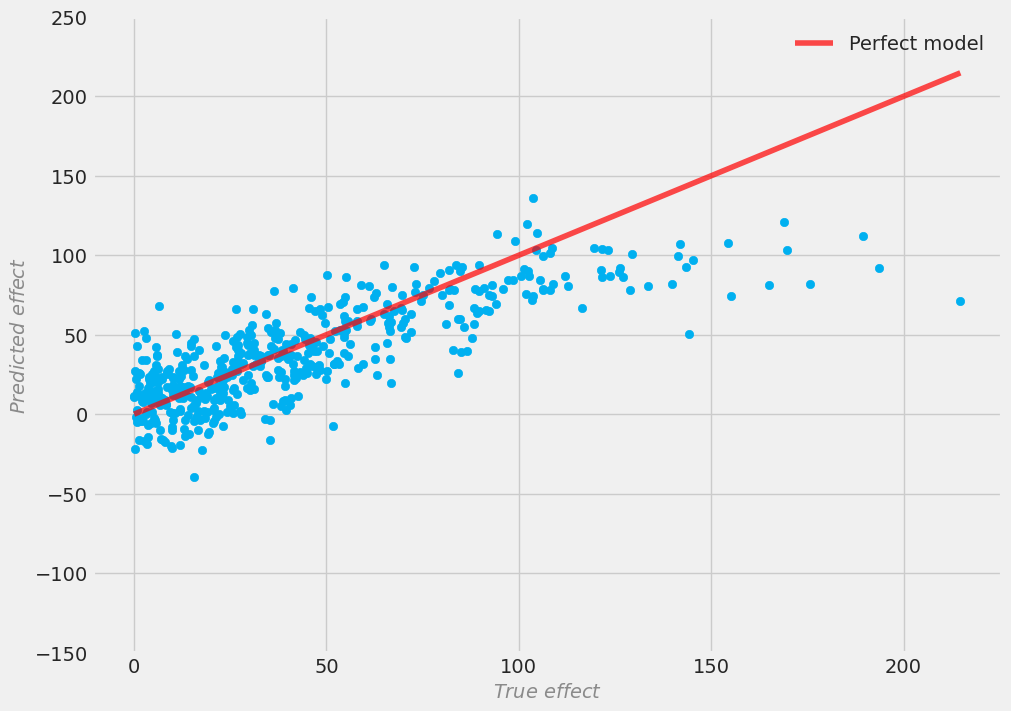

XLearner MAPE = 4.256912689213058


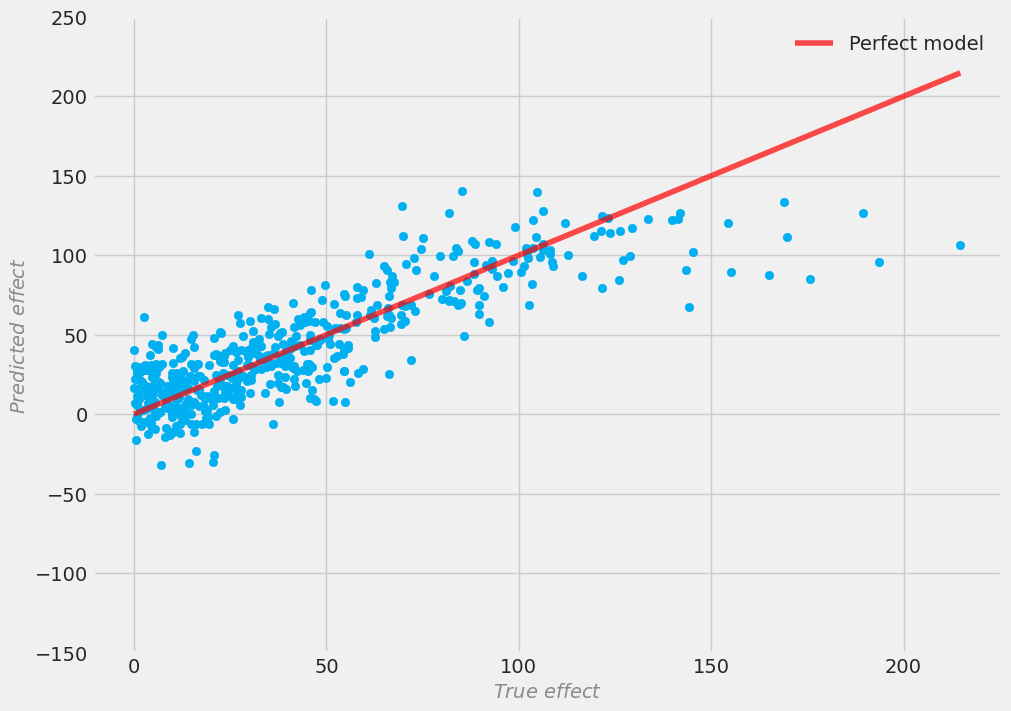

DRLearner MAPE = 8.642613444611376


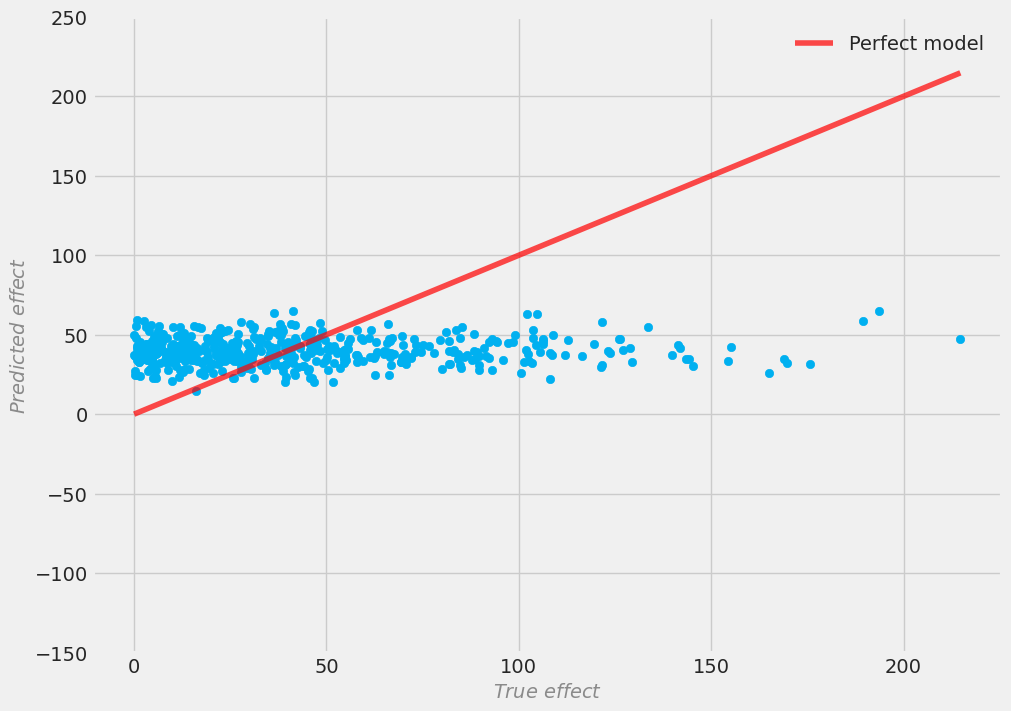

CausalForest MAPE = 3.248021227032013


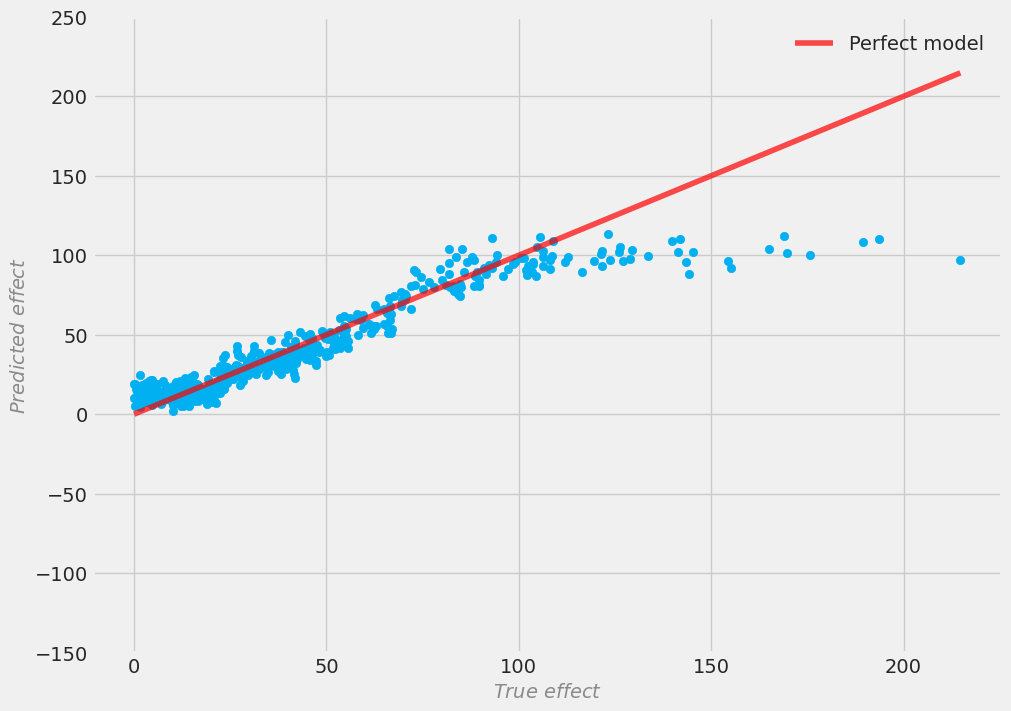

In [16]:
for model_name in benchmark_results.keys():
    effect_pred = benchmark_results[model_name]
    print(f'{model_name} MAPE = {mean_absolute_percentage_error(effect_true, effect_pred)}')
    
    plot_effect(
        effect_true=effect_true,
        effect_pred=effect_pred,
        ylim=(-150, 250)
    )

### TARNet

In [699]:
tarnet = TARNet(
    n_unit_in=X.shape[1],
    binary_y=False,
    n_units_out_prop=32,
    n_units_r=8,
    nonlin='selu',
)

tarnet.fit(
    X=X[:TRAIN_SIZE, :],
    y=y[:TRAIN_SIZE],
    w=T[:TRAIN_SIZE]
);


In [700]:
# Get predictions
effect_pred_tarnet = tarnet.predict(
    X=X[TRAIN_SIZE:, :]
).cpu().detach().numpy()

In [701]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred_tarnet)

In [703]:
?mean_absolute_percentage_error

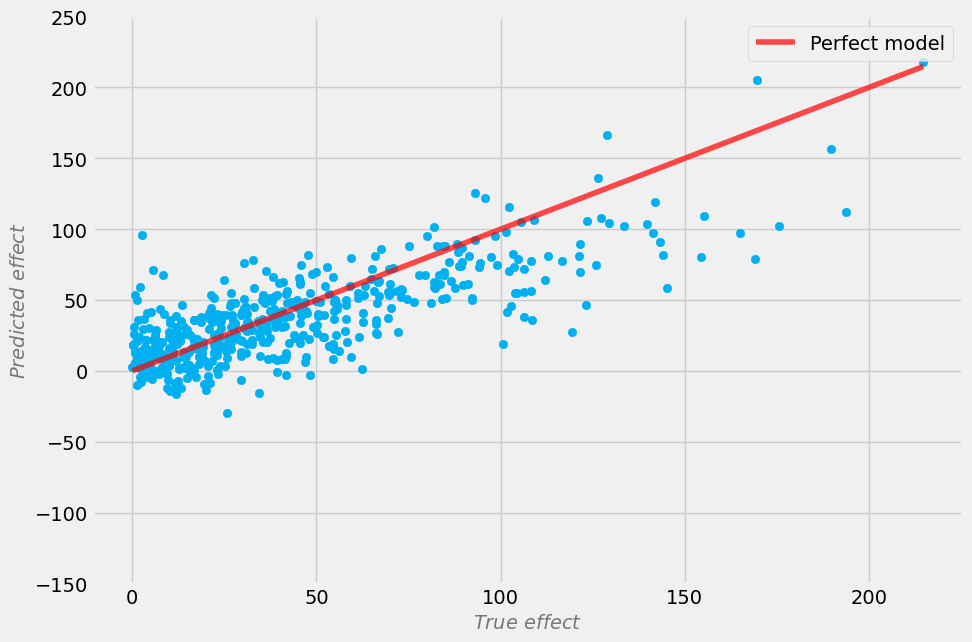

In [702]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred_tarnet,
    ylim=(-150, 250)
)

### SNet

In [679]:
snet = SNet(
    n_unit_in=X.shape[1],
    binary_y=False,
    n_units_out_prop=32,
    n_units_r=8,
    nonlin='selu',
)

snet.fit(
    X=X[:TRAIN_SIZE, :],
    y=y[:TRAIN_SIZE],
    w=T[:TRAIN_SIZE]
);

In [680]:
effect_pred_snet = snet.predict(
    X=X[TRAIN_SIZE:, :]
).cpu().detach().numpy()

In [681]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred_snet)

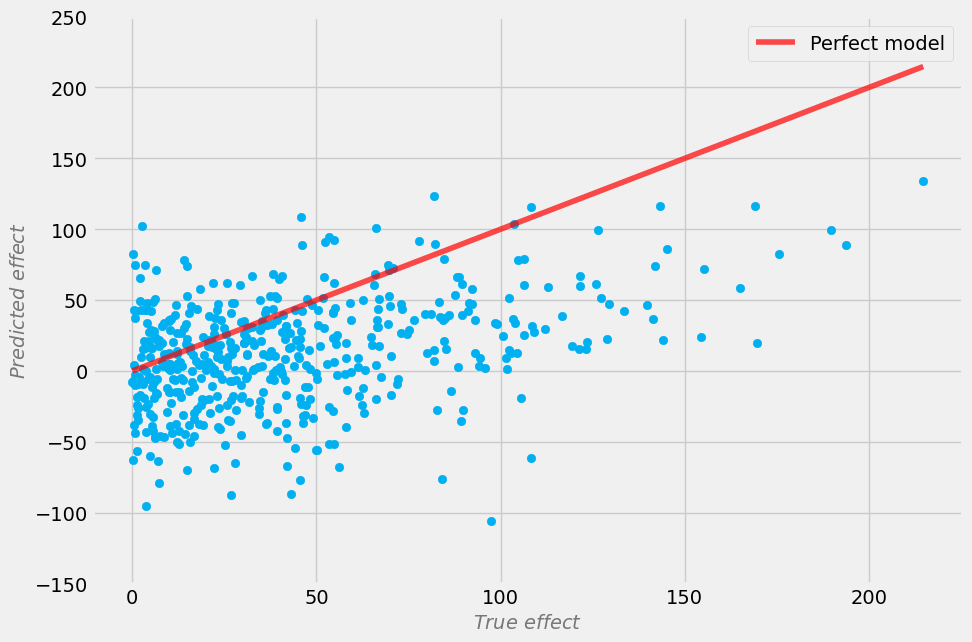

In [683]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
    ylim=(-150, 250)
)

## Transformers and Causal Inference

### Data

In [49]:
# Read-in
df = pd.read_csv('data/manga_processed.csv')          

In [53]:
# Shuffle observations
df = df.sample(frac=1)

In [54]:
df.head()

,text,subreddit,female_avatar,has_photo,upvote
111,I'm obsessed with 'My Hero Academia' and its t...,manga,0,0,1
47,Can we talk about how 'Chihayafuru' is a beaut...,manga,1,0,0
148,I'm amazed by 'Naruto' and its epic and emotio...,manga,0,0,1
151,I'm blown away by 'Fullmetal Alchemist' and it...,manga,0,1,1
92,Looking for manga that deal with the themes of...,manga,1,1,0


In [48]:
df.shape

### Modeling

In [33]:
# Re-running the model training? Un-comment the lines below and collect garbarge to free the GPU memory
# import gc
# del causal_bert
# gc.collect()
# torch.cuda.empty_cache()

# torch.cuda.is_available()

True

In [34]:
# Instantiate the model
causal_bert = CausalBertWrapper(
    batch_size=8,                      
    g_weight=0.05, 
    Q_weight=1., 
    mlm_weight=0.05
)

Some weights of CausalBert were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['Q_cls.1.2.weight', 'g_cls.bias', 'Q_cls.1.2.bias', 'Q_cls.0.0.weight', 'g_cls.weight', 'Q_cls.0.2.bias', 'Q_cls.1.0.bias', 'Q_cls.1.0.weight', 'Q_cls.0.2.weight', 'Q_cls.0.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# Train
causal_bert.train(
    texts=df['text'], 
    confounds=df['has_photo'], 
    treatments=df['female_avatar'], 
    outcomes=df['upvote'], 
    epochs=6
);

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:08<00:00,  3.44it/s]


In [36]:
# Predict
preds = causal_bert.inference(
    texts=df['text'],
    confounds=df['has_photo'], 
)[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.68it/s]


In [37]:
# Compute ATE
np.mean(preds[:, 1] - preds[:, 0])